# Background Detail Real-Valued - Story 1

This notebook assesses inter-annotator agreement for the background detail/information amount score. 
It imports JSON files to perform a number of statistical tests to assess inter-annotator agreement. 

##### Imports and packages

In [1]:
# Imports and Packages:

import json # json library
import os # for list directories 

from collections import Counter # counter library
import re # regex

import numpy as np 
import math
import matplotlib.pyplot as plt

import itertools
from itertools import permutations # library to print permutations
from itertools import combinations # library to print combinations

import sklearn # sklearn for inter-annotation kappa scores
from sklearn.metrics import cohen_kappa_score
import statsmodels
from statsmodels.stats.inter_rater import fleiss_kappa

#import krippendorff #import for Fleiss Kappa inter-annotator agreement for more than 2 annotators

import scipy.stats
from scipy.stats import mode 
from scipy.stats import zscore # normalise data
from scipy.stats import mannwhitneyu # for Mann-Whitney U test
from scipy.stats import ttest_ind # independent t-test
from scipy.stats import spearmanr # spearmans rank
from scipy.stats import pearsonr # pearson's r



##### Import JSON data

In [2]:
# Import JSON data from Prolific Study

path_to_jsonFiles = "Annotations_Prolific/Background_Detail_RealValue_Story1/Processed_Data" # This is the folder with the json data files
corpus_study2 = {} # init a dict to hold each json data file
participantNum = 1 # init a participant num counter

for file in sorted(os.listdir(path_to_jsonFiles)):
    if file.endswith('.json'): # check that the file has a json extension (to circumvent hidden .DS_store files)
        full_file_name = "%s/%s" % (path_to_jsonFiles, file)
        with open(full_file_name, 'r') as fi:
            storyName = "participant" + str(participantNum)
            story_data = json.load(fi)
            corpus_study2[storyName] = story_data
        participantNum += 1
    
# all_stories holds all the json data files, with key "storyN" and value is the read in json file



In [3]:
# check that the data was read in correctly
#corpus_study2['participant10']

In [4]:
# Import JSON data from Original Annotation study - story 1

# Story 1
#file1 = open("Annotations_Round1/JSON_cleaned/Participant0_Story1.json")
#file2 = open("Annotations_Round1/JSON_cleaned/Participant1_Story1.json")
#file3 = open("Annotations_Round1/JSON_cleaned/Participant2_Story1.json")
#file4 = open("Annotations_Round1/JSON_cleaned/Participant3_Story1.json")
#file5 = open("Annotations_Round1/JSON_cleaned/Participant6_Story1.json")
#file6 = open("Annotations_Round1/JSON_cleaned/Participant7_Story1.json")
#file7 = open("Annotations_Round1/JSON_cleaned/Participant8_Story1.json")

#participant0_study1 = json.load(file1) # Story 1
#participant1_study1 = json.load(file2)
#participant2_study1 = json.load(file3)
#participant3_study1 = json.load(file4)
#participant6_study1 = json.load(file5)
#participant7_study1 = json.load(file6)
#participant8_study1 = json.load(file7)

#corpus_study1 = {"participant0_study1" : participant0_study1,
                 #"participant1_study1" : participant1_study1,
                 #"participant2_study1" : participant2_study1,
                 #"participant3_study1" : participant3_study1,
                 #"participant6_study1" : participant6_study1,
                 #"participant7_study1" : participant7_study1,
                 #"participant8_study1" : participant8_study1
                #} 


In [5]:
# check that the data was read in correctly
#corpus_study1["participant8_study1"]

In [6]:
# corpus_study1 - data from story 1, experiment 1 (Binary categorical data)
# corpus_study2 - data from story 2, experiment 2 (Real valued data, between 1 and 5)


##### Get annotator pair combinations as pairs of names in a list

In [7]:
# Combinations of annotators:
# Function to get the combinations of all participants

def get_combinations_of_annotators(all_annotation_data):
    """
    Takes: a dict containing all annotation data - this is the input of reading in all json files,
            as is done above.
    Returns: a list of tuples containing pairs of strings that indicate annotators. In other words, a list of 
            annotator pairs.
    """
    annotators = [] # init a list to store annotators
    annotator_pairs = [] # init a list to store all combination pairs
    
    for annotator, annotation_data in all_annotation_data.items():
        annotators.append(annotator)
     
    combs = itertools.combinations(annotators, 2) # get annotator combinations in sets of two
    
    for ann in list(combs):
        annotator_pairs.append(ann)
    
    return annotator_pairs


In [8]:
combinations_all_participants_study2 = get_combinations_of_annotators(corpus_study2)



In [9]:

# get a list of all values per participant for STUDY 2

background_values = {}

for participant, story_info in corpus_study2.items():
    values = [] # init values list
    for page, page_info in story_info.items():
        for panel, panel_info in page_info.items():
            background_info = panel_info["background/setting"]
            value = float(background_info["information_amount"])
            values.append(value)
    
    background_values[participant] = values


In [10]:
#background_values

##### Store the annotation values per annotator in a dictionary and list of lists for easier analysis

In [11]:
# put all sets of background values into a list of lists

list_of_lists_of_all_participant_values = []
for participant, values_list in background_values.items():
    #print(participant)
    #print(values_list)
    list_of_lists_of_all_participant_values.append(values_list)
    
print(len(list_of_lists_of_all_participant_values))


10


### Krippendorff's Alpha

##### Function to calculate Krippendorff's Alpha

In [12]:
# Krippendorff's Alpha - Inter-rater agreement measure

# Code from https://github.com/grrrr/krippendorff-alpha/blob/master/krippendorff_alpha.py

def nominal_metric(a, b):
    return a != b

def interval_metric(a, b):
    return (a-b)**2

def ratio_metric(a, b):
    return ((a-b)/(a+b))**2

def krippendorff_alpha(data, metric=interval_metric, force_vecmath=False, convert_items=float, missing_items=None):
    '''
    Python implementation of Krippendorff's alpha -- inter-rater reliability
    (c)2011-17 Thomas Grill (http://grrrr.org)
    Python version >= 2.4 required

    Calculate Krippendorff's alpha (inter-rater reliability):
    
    data is in the format
    [
        {unit1:value, unit2:value, ...},  # coder 1
        {unit1:value, unit3:value, ...},   # coder 2
        ...                            # more coders
    ]
    or it is a sequence of (masked) sequences (list, numpy.array, numpy.ma.array, e.g.) with rows corresponding to 
    coders and columns to items
    
    metric: function calculating the pairwise distance
    force_vecmath: force vector math for custom metrics (numpy required)
    convert_items: function for the type conversion of items (default: float)
    missing_items: indicator for missing items (default: None)
    '''
    
    # number of coders
    m = len(data)
    
    # set of constants identifying missing values
    if missing_items is None:
        maskitems = []
    else:
        maskitems = list(missing_items)
    if np is not None:
        maskitems.append(np.ma.masked_singleton)
    
    # convert input data to a dict of items
    units = {}
    for d in data:
        try:
            # try if d behaves as a dict
            diter = d.items()
        except AttributeError:
            # sequence assumed for d
            diter = enumerate(d)
            
        for it, g in diter:
            if g not in maskitems:
                try:
                    its = units[it]
                except KeyError:
                    its = []
                    units[it] = its
                its.append(convert_items(g))


    units = dict((it, d) for it, d in units.items() if len(d) > 1)  # units with pairable values
    n = sum(len(pv) for pv in units.values())  # number of pairable values
    
    if n == 0:
        raise ValueError("No items to compare.")
    
    np_metric = (np is not None) and ((metric in (interval_metric, nominal_metric, ratio_metric)) or force_vecmath)
    
    Do = 0.
    for grades in units.values():
        if np_metric:
            gr = np.asarray(grades)
            Du = sum(np.sum(metric(gr, gri)) for gri in gr)
        else:
            Du = sum(metric(gi, gj) for gi in grades for gj in grades)
        Do += Du/float(len(grades)-1)
    Do /= float(n)

    if Do == 0:
        return 1.

    De = 0.
    for g1 in units.values():
        if np_metric:
            d1 = np.asarray(g1)
            for g2 in units.values():
                De += sum(np.sum(metric(d1, gj)) for gj in g2)
        else:
            for g2 in units.values():
                De += sum(metric(gi, gj) for gi in g1 for gj in g2)
    De /= float(n*(n-1))

    return 1.-Do/De if (Do and De) else 1.



##### Krippendorff's Alpha result for all-against-all annotators, using the above function 

In [13]:
kalpha = krippendorff_alpha(list_of_lists_of_all_participant_values, interval_metric) # get the k alpha for each ind agent
print(kalpha)


0.4645755015666333


##### Krippendorff's Alpha result for all-against-all annotators, using the Krippendorff 0.7.0 Python package

In [14]:
import krippendorff
from krippendorff.krippendorff import alpha


In [15]:
print(krippendorff.alpha(list_of_lists_of_all_participant_values, level_of_measurement="ratio"))

0.5033662262020531


##### Krippendorff's Alpha results for all individual annotator pairs

In [16]:
KA_values = []
for participant_pair in combinations_all_participants_study2:
    ann1 = participant_pair[0]
    ann2 = participant_pair[1]
    KA_value = krippendorff_alpha([background_values[ann1], background_values[ann2]])
    KA_values.append(KA_value)
    
print("Pairwise KA values: \n")
print(KA_values)
print("\n")
print("mean: ", np.mean(KA_values))
print("std: ", np.std(KA_values))

#print(background_values[ann1])

Pairwise KA values: 

[0.4480721971476941, 0.46863939630047224, 0.3820191946781474, 0.2736367115174374, 0.38545489294190616, 0.2865082205506525, 0.6901593005108876, 0.10993490682265072, 0.5454230401677014, 0.6975106732168053, 0.3479826908113245, 0.46364880285786425, 0.7806560588400262, 0.4853316075495133, 0.5053906332730944, 0.4476862847147248, 0.7162114712837369, 0.5853992514010338, 0.6333550344492714, 0.4647660419054035, 0.4240905196166995, 0.479566125614844, 0.4534543686978014, 0.8833160432554767, 0.7290924668991974, 0.3712706008545785, 0.10044872179534992, 0.32266378869724244, 0.14580321494883364, 0.6387491740442177, 0.4243043583037188, 0.12185721187094367, 0.20435614573723915, 0.21797893926341383, 0.6710630469073784, 0.3205090019732736, 0.48615127822454285, 0.39981082443872307, 0.5894495178181278, 0.28223594234128535, 0.5877901052125003, 0.39311079055701426, 0.2174721383463637, 0.476111636903479, 0.4475795305999968]


mean:  0.446800486752502
std:  0.18342460046435427


### Per-panel analysis of annotator agreement

##### Get all annotators raw values and z-score normalised values per panel 

In [17]:
# z-score normalisation - normalise the raw background values for STUDY 2

zscore_values = {}

for participant, values in background_values.items():
    int_values =  [float(i) for i in values]
    normalised_values = zscore(int_values)
    
    zscore_values[participant] = list(normalised_values)
    

In [18]:
#zscore_values

In [19]:
# Get each zscore value per panel 

zscores_per_panel = {}

for participant, values in zscore_values.items():
    panelNum = 0
    for val in values:
        panelName = panelNum + 1
        if zscores_per_panel.get(panelName) == None:
            zscores_per_panel[panelName] = []
        if zscores_per_panel.get(panelName) != None:
            zscores_per_panel[panelName].append(val)
        panelNum += 1
    


In [20]:
# Get each zscore value per panel 

raw_score_per_panel = {}

for participant, values in background_values.items():
    panelNum = 0
    for val in values:
        panelName = panelNum + 1
        if raw_score_per_panel.get(panelName) == None:
            raw_score_per_panel[panelName] = []
        if raw_score_per_panel.get(panelName) != None:
            raw_score_per_panel[panelName].append(val)
        panelNum += 1
    


In [21]:
#raw_score_per_panel

In [22]:
# mean z_score per panel

normalised_mean_per_panel = {}

for panelNum, scores in zscores_per_panel.items():
    normalised_mean_per_panel[panelNum] = np.mean(scores)



In [23]:
normalised_mean_per_panel

{1: 0.5035065172640272,
 2: -0.48279488514091085,
 3: 1.0600113071008848,
 4: -0.8224567013773548,
 5: 0.14405973205391528,
 6: -0.5062092653865365,
 7: -0.416640470497184,
 8: 0.12597314814742358,
 9: -0.753531795694013,
 10: 0.9507362864932869,
 11: 1.080657073717065,
 12: 0.09781420137030442,
 13: -0.8665192072545033,
 14: 0.5606753577908286,
 15: -0.764989107791141,
 16: -0.9025943947646671,
 17: -0.9076674680082839,
 18: 1.647832617296108,
 19: 0.9364818469406856,
 20: -0.838020863075115,
 21: 0.8750968575030239,
 22: -0.45670097352829,
 23: 0.46187982565688623,
 24: -0.6910894083430499,
 25: 0.6578656520665804,
 26: 0.838740101212516,
 27: 1.1500779007478579,
 28: -0.5824120305606103,
 29: -0.5063837294436847,
 30: -0.33496475131676634,
 31: -0.5752181568146806,
 32: -0.6832152163646033}

In [24]:
# just means in a list without panel

continuous_story1_just_means_normalised = []

for panel, mean in normalised_mean_per_panel.items():
    continuous_story1_just_means_normalised.append(mean)
    

In [25]:
continuous_story1_just_means_normalised

[0.5035065172640272,
 -0.48279488514091085,
 1.0600113071008848,
 -0.8224567013773548,
 0.14405973205391528,
 -0.5062092653865365,
 -0.416640470497184,
 0.12597314814742358,
 -0.753531795694013,
 0.9507362864932869,
 1.080657073717065,
 0.09781420137030442,
 -0.8665192072545033,
 0.5606753577908286,
 -0.764989107791141,
 -0.9025943947646671,
 -0.9076674680082839,
 1.647832617296108,
 0.9364818469406856,
 -0.838020863075115,
 0.8750968575030239,
 -0.45670097352829,
 0.46187982565688623,
 -0.6910894083430499,
 0.6578656520665804,
 0.838740101212516,
 1.1500779007478579,
 -0.5824120305606103,
 -0.5063837294436847,
 -0.33496475131676634,
 -0.5752181568146806,
 -0.6832152163646033]

In [26]:
# STD for the z_score of each panel

STD_per_panel = {}

for panelNum, scores in zscores_per_panel.items():
    STD_per_panel[panelNum] = np.std(scores)


In [27]:
STD_per_panel

{1: 1.09984758814964,
 2: 0.5898326424218676,
 3: 0.9403136691891636,
 4: 0.25279489529306765,
 5: 0.5822375602478465,
 6: 0.42186355867456515,
 7: 0.5404375401535711,
 8: 0.7091529188096044,
 9: 0.2486806099873068,
 10: 0.7609792859463881,
 11: 0.8690948281870489,
 12: 0.5537119545302821,
 13: 0.20888652646104605,
 14: 0.6303640865047246,
 15: 0.2684462133156614,
 16: 0.1671501579930997,
 17: 0.16616522738735107,
 18: 0.8752028304943061,
 19: 0.9997877112559471,
 20: 0.24374530144142256,
 21: 0.848983601768046,
 22: 0.5337598211849102,
 23: 0.6705426102358316,
 24: 0.2740327509568076,
 25: 1.0233395097098457,
 26: 0.8743402149020161,
 27: 0.8429178415359359,
 28: 0.5298334519150802,
 29: 0.20578454241553615,
 30: 0.7993602762176345,
 31: 0.35911355744002255,
 32: 0.5716649564357}

In [28]:
# just stds in a list without panel

continuous_story1_just_stds_normalised = []

for panel, std in STD_per_panel.items():
    continuous_story1_just_stds_normalised.append(std)
    

In [29]:
continuous_story1_just_stds_normalised

[1.09984758814964,
 0.5898326424218676,
 0.9403136691891636,
 0.25279489529306765,
 0.5822375602478465,
 0.42186355867456515,
 0.5404375401535711,
 0.7091529188096044,
 0.2486806099873068,
 0.7609792859463881,
 0.8690948281870489,
 0.5537119545302821,
 0.20888652646104605,
 0.6303640865047246,
 0.2684462133156614,
 0.1671501579930997,
 0.16616522738735107,
 0.8752028304943061,
 0.9997877112559471,
 0.24374530144142256,
 0.848983601768046,
 0.5337598211849102,
 0.6705426102358316,
 0.2740327509568076,
 1.0233395097098457,
 0.8743402149020161,
 0.8429178415359359,
 0.5298334519150802,
 0.20578454241553615,
 0.7993602762176345,
 0.35911355744002255,
 0.5716649564357]

##### Sort by least agreed to most agreed panel

In [30]:
# get five highest and five lowest:
        
import operator
sorted_STD_per_panel = sorted(STD_per_panel.items(), key=operator.itemgetter(1))

print(sorted_STD_per_panel)


[(17, 0.16616522738735107), (16, 0.1671501579930997), (29, 0.20578454241553615), (13, 0.20888652646104605), (20, 0.24374530144142256), (9, 0.2486806099873068), (4, 0.25279489529306765), (15, 0.2684462133156614), (24, 0.2740327509568076), (31, 0.35911355744002255), (6, 0.42186355867456515), (28, 0.5298334519150802), (22, 0.5337598211849102), (7, 0.5404375401535711), (12, 0.5537119545302821), (32, 0.5716649564357), (5, 0.5822375602478465), (2, 0.5898326424218676), (14, 0.6303640865047246), (23, 0.6705426102358316), (8, 0.7091529188096044), (10, 0.7609792859463881), (30, 0.7993602762176345), (27, 0.8429178415359359), (21, 0.848983601768046), (11, 0.8690948281870489), (26, 0.8743402149020161), (18, 0.8752028304943061), (3, 0.9403136691891636), (19, 0.9997877112559471), (25, 1.0233395097098457), (1, 1.09984758814964)]


In [31]:
# Mean for the raw score of each panel

mean_per_panel = {}

for panelNum, scores in raw_score_per_panel.items():
    mean_per_panel[panelNum] = np.mean(scores)


In [32]:
#mean_per_panel

In [33]:
# just means in a list without panel

continuous_story1_just_means = []

for panel, mean in mean_per_panel.items():
    continuous_story1_just_means.append(mean)


In [34]:
continuous_story1_just_means

[2.7384462623766543,
 1.3688833780700562,
 3.211270671582561,
 1.079433873164067,
 2.080107631213776,
 1.36514255774308,
 1.645498908663783,
 2.129475849191201,
 1.1794952857749312,
 3.1362271158858865,
 3.391725988702465,
 2.1887614086892326,
 1.031294311624073,
 2.8049364526896428,
 1.179522611101519,
 1.003858202802968,
 1.0,
 3.934305901650758,
 3.1322732584049233,
 1.0604781533388299,
 2.9380408547259282,
 1.395988752129989,
 2.616883798234035,
 1.202916414435785,
 2.6883931842464883,
 2.9501598649927,
 3.186739348542791,
 1.261271430427154,
 1.420210909005188,
 1.826685180247825,
 1.330879003042054,
 1.338647421451102]

In [35]:
#background_values

In [36]:
# get a list of all values per participant for STUDY 1

# background_values_study1 = {}

# for participant, story_info in corpus_study1.items():
#     values = [] # init values list
#     #print(story_info)
#     for page, page_info in story_info.items():
#         #print(page_info)
#         for panel, panel_info in page_info.items():
#             background_info = panel_info["background"]
#             #print(background_info)
#             value = background_info["detail"]
#             #print(value)
#             if value == False:
#                 values.append(0)
#             if value == True:
#                 values.append(1)
            
#     background_values_study1[participant] = values
            


In [37]:
# background_values_study1["participant7_study1"].append(0)

# for participant, info in background_values_study1.items():
#     print(info)
    

## Pearson's r and Spearman's rank between annotator pairs

In [38]:
# Check the linearity of the data

covariance_values = []
for participant_pair in combinations_all_participants_study2:
    ann1 = participant_pair[0]
    ann2 = participant_pair[1]
    cov_value = np.cov(background_values[ann1], background_values[ann2])
    print(ann1 + " and " + ann2 + ": " + str(cov_value))
    covariance_values.append(cov_value)
#print("********************")
#print(covariance_values)


participant1 and participant2: [[1.75379125 0.60708819]
 [0.60708819 1.00448642]]
participant1 and participant3: [[1.75379125 0.79834796]
 [0.79834796 1.36554586]]
participant1 and participant4: [[1.75379125 1.03988355]
 [1.03988355 2.6039008 ]]
participant1 and participant5: [[1.75379125 0.73215876]
 [0.73215876 2.51373797]]
participant1 and participant6: [[1.75379125 0.58256649]
 [0.58256649 1.33109252]]
participant1 and participant7: [[1.75379125 0.30580117]
 [0.30580117 0.46071953]]
participant1 and participant8: [[1.75379125 0.85469019]
 [0.85469019 0.71971442]]
participant1 and participant9: [[1.75379125 0.11747567]
 [0.11747567 0.59705745]]
participant1 and participant10: [[1.75379125 1.05413733]
 [1.05413733 1.8341594 ]]
participant2 and participant3: [[1.00448642 0.89259096]
 [0.89259096 1.36554586]]
participant2 and participant4: [[1.00448642 0.80164576]
 [0.80164576 2.6039008 ]]
participant2 and participant5: [[1.00448642 0.96987192]
 [0.96987192 2.51373797]]
participant2 an

##### Functions to calculate Spearman's rank and Pearsons r

In [41]:

# Spearman's rank function 

def get_spearmans_rank(values_Ann1, values_Ann2):
    """
    Takes: two lists of values
    Returns: nothing, but prints the the p value and states whether the null hypothesis was rejected.
    """
    # compare samples
    coef, p = spearmanr(values_Ann1, values_Ann2)
    print('Spearmans correlation coefficient: %.3f' % coef)
    # interpret the significance
    alpha = 0.05
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)
        
    return coef, p



In [42]:

# Pearson's r function 

def get_pearsonsr(values_Ann1, values_Ann2):
    """
    Takes: two lists of values
    Returns: nothing, but prints the the p value and states whether the null hypothesis was rejected.
    """

    
    # compare samples
    coef, p = pearsonr(values_Ann1, values_Ann2)
    print('Pearsons correlation coefficient: %.3f' % coef)
    # interpret the significance
    alpha = 0.05
    if p > alpha:
        print('Samples are uncorrelated (fail to reject H0) p=%.3f' % p)
    else:
        print('Samples are correlated (reject H0) p=%.3f' % p)
    
    return coef, p



##### Calculate Pearson's r scores between each annotator pair

In [45]:
# STUDY 2 - Calculate Pearson's r between all combinations of annotators 

corr = 0
not_corr = 0

pearsons_values_study2 = []
for participant_pair in combinations_all_participants_study2:
    ann1 = participant_pair[0]
    ann2 = participant_pair[1]
    print(ann1 + " and " + ann2 + ":")
    #print(background_values[ann1])
    #print(background_values[ann2])
    pearsons_value, p = get_pearsonsr(background_values[ann1], background_values[ann2])
    if p > 0.01:
        corr +=1
    if p < 0.01:
        not_corr +=1
    pearsons_values_study2.append(pearsons_value)
    print("********************")
print(pearsons_values_study2)
print("correlated: ", corr)
print("not correlated: ", not_corr)
print("mean: ", np.mean(pearsons_values_study2))
print("std: ", np.std(pearsons_values_study2))



participant1 and participant2:
Pearsons correlation coefficient: 0.457
Samples are correlated (reject H0) p=0.008
********************
participant1 and participant3:
Pearsons correlation coefficient: 0.516
Samples are correlated (reject H0) p=0.003
********************
participant1 and participant4:
Pearsons correlation coefficient: 0.487
Samples are correlated (reject H0) p=0.005
********************
participant1 and participant5:
Pearsons correlation coefficient: 0.349
Samples are uncorrelated (fail to reject H0) p=0.050
********************
participant1 and participant6:
Pearsons correlation coefficient: 0.381
Samples are correlated (reject H0) p=0.031
********************
participant1 and participant7:
Pearsons correlation coefficient: 0.340
Samples are uncorrelated (fail to reject H0) p=0.057
********************
participant1 and participant8:
Pearsons correlation coefficient: 0.761
Samples are correlated (reject H0) p=0.000
********************
participant1 and participant9:
Pear

In [46]:


# STUDY 2 - Calculate Pearson's r between all combinations of annotators - zscore 

pearsons_values_zscore = []
for participant_pair in combinations_all_participants_study2:
    ann1 = participant_pair[0]
    ann2 = participant_pair[1]
    print(ann1 + " and " + ann2 + ":")
    print(zscore_values[ann1])
    print(zscore_values[ann2])
    pearsons_valuez = get_pearsonsr(zscore_values[ann1], zscore_values[ann2])
    pearsons_values_zscore.append(pearsons_valuez)
print("********************")    
print(pearsons_values_zscore)
    

participant1 and participant2:
[2.1263859853081204, -0.5687228667427313, 2.4441421777586902, -0.6246337891404825, -0.26994096922353, -0.6246337891404825, -0.6246337891404825, -0.6157791181725133, -0.6246337891404825, -0.5596152051756776, 1.1523721788314691, -0.38656963540164374, -0.6246337891404825, -0.09310054046322258, -0.6246337891404825, -0.6246337891404825, -0.6246337891404825, 0.5806134248997211, 2.4441421777586902, -0.6246337891404825, 1.7152762617952484, -0.20694631005140027, 1.7079395344217934, -0.6246337891404825, -0.6246337891404825, -0.6246337891404825, 0.6724490123675183, -0.6246337891404825, -0.6246337891404825, -0.6246337891404825, -0.14850548166280514, -0.6246337891404825]
[-0.7496626153927716, -0.8833779727828543, 2.2749787687709992, -0.8833779727828543, 0.7750267472476952, -0.8833779727828543, -0.8833779727828543, 1.238016172210871, -0.3491851200094521, 2.2067839365020543, 1.4730209128239573, -0.41604279870449873, -0.8833779727828543, 0.7395921775393243, -0.8833779727

In [47]:
# STUDY 2 - Calculate Pearson's r between all combinations of annotators WITHOUT PARTICIPANT 1

#del background_values["participant1"]
#background_values

#combinations_4participants_study2 = get_combinations_of_annotators(background_values)
#print(combinations_4participants_study2)

#pearsons_values_study2_4participants = []
#for participant_pair in combinations_4participants_study2:
    #ann1 = participant_pair[0]
    #ann2 = participant_pair[1]
    #pearsons_value = get_pearsonsr(background_values[ann1], background_values[ann2])
    #pearsons_values_study2_4participants.append(pearsons_value)
    
#print(pearsons_values_study2_4participants)



##### Calculate Spearman's rank between each annotator pair

In [49]:
# STUDY 2 - Calculate Spearman's r between all combinations of annotators - raw score

corr = 0
not_corr = 0

spearmans_values_rawScore = []
for participant_pair in combinations_all_participants_study2:
    ann1 = participant_pair[0]
    ann2 = participant_pair[1]
    print(ann1 + " and " + ann2 + ":")
    spearmans_value, p = get_spearmans_rank(background_values[ann1], background_values[ann2])
    if p < 0.01:
        corr +=1
    if p > 0.01:
        not_corr +=1
    spearmans_values_rawScore.append(spearmans_value)
    print("********************")
print(spearmans_values_rawScore)
print("correlated: ", corr)
print("not correlated: ", not_corr)
print("mean: ", np.mean(spearmans_values_rawScore))
print("std: ", np.std(spearmans_values_rawScore))


participant1 and participant2:
Spearmans correlation coefficient: 0.643
Samples are correlated (reject H0) p=0.000
********************
participant1 and participant3:
Spearmans correlation coefficient: 0.646
Samples are correlated (reject H0) p=0.000
********************
participant1 and participant4:
Spearmans correlation coefficient: 0.577
Samples are correlated (reject H0) p=0.001
********************
participant1 and participant5:
Spearmans correlation coefficient: 0.469
Samples are correlated (reject H0) p=0.007
********************
participant1 and participant6:
Spearmans correlation coefficient: 0.474
Samples are correlated (reject H0) p=0.006
********************
participant1 and participant7:
Spearmans correlation coefficient: 0.485
Samples are correlated (reject H0) p=0.005
********************
participant1 and participant8:
Spearmans correlation coefficient: 0.829
Samples are correlated (reject H0) p=0.000
********************
participant1 and participant9:
Spearmans correla

In [50]:
# STUDY 2 - Calculate Spearman's r between all combinations of annotators - zscore 

# spearmans_values_zscore = []
# for participant_pair in combinations_all_participants_study2:
#     ann1 = participant_pair[0]
#     ann2 = participant_pair[1]
#     print(ann1 + " and " + ann2 + ":")
#     spearmans_value = get_spearmans_rank(zscore_values[ann1], zscore_values[ann2])
#     spearmans_values_zscore.append(spearmans_value)
#     print("********************")
# print(spearmans_values_zscore)


In [51]:
# # Study 1 - Calculate Pearson's r between all combinations of annotators

# pearsons_values_study1 = []
# for participant_pair in combinations_all_participants_study1:
#     ann1 = participant_pair[0]
#     ann2 = participant_pair[1]
#     pearsons_value = get_pearsonsr(background_values_study1[ann1], background_values_study1[ann2])
#     pearsons_values_study1.append(pearsons_value)
    
# print(pearsons_values_study1)



In [52]:

# mean_study1 = np.mean(pearsons_values_study1)
# std_study1 = np.std(pearsons_values_study1)
# range_study1 = (min(pearsons_values_study1), max(pearsons_values_study1))
mean_study2 = np.mean(pearsons_values_study2)
std_study2 = np.std(pearsons_values_study2)
range_study2 = (min(pearsons_values_study2), max(pearsons_values_study2))


# print("mean pearsons correlation study1: ", mean_study1)
# print("std: ", std_study1)
# print("range", range_study1)
print("mean pearsons correlation: ", mean_study2)
print("std: ", std_study2)
print("range", range_study2)



mean pearsons correlation:  0.5352625060041508
std:  0.16414340801099161
range (0.11480239097125342, 0.8911029272240798)


In [53]:

# get all the values per panel/segmentation
def get_values_per_pages_panel(corpus_dict, zscores):
    """
    Takes: a corpus dict - this one only works for study 2
    Returns: a dict with a list of values of all annotators per panel in the story, setup as a 
        dict of pages, with the values panels, with the values of lists of floats. 
        Also adds the z_score normalised scores. 
    """
    
    all_values_per_panel = {} # init dict
    
    #print(zscores)

    for participant, story_info in corpus_dict.items():
        zscore_value_index = 0 # init an index to get the correct zscore from the array
        for page, page_info in story_info.items():
            if all_values_per_panel.get(page) == None: # if this page has not been initialized in the final dict,
                all_values_per_panel[page] = {} # create it here
            for panel, panel_info in page_info.items():
                if all_values_per_panel[page].get(panel) == None: # if this panel has not been initialized, 
                    all_values_per_panel[page][panel] = [] # create it here
                background_detail = float(panel_info["background/setting"]["information_amount"]) # get value
                zscore_value = zscores[participant][zscore_value_index]
                #score_tuple = [background_detail, zscore_value]
                #print(participant)
                #print(zscore_value)
                #print(score_tuple)
                all_values_per_panel[page][panel].append(zscore_value)
                zscore_value_index += 1
               # print(zscore_value_index)
                
    #print(all_values_per_panel)
                
    return all_values_per_panel
    
        

In [54]:
values_per_panel = get_values_per_pages_panel(corpus_study2, zscore_values)

In [55]:
values_per_panel

{'page1': {'panel1': [2.1263859853081204,
   -0.7496626153927716,
   -0.07463374094628883,
   1.4996674747208412,
   1.314524789203093,
   -0.18293980734654028,
   -0.6186900106359745,
   2.237094833384168,
   -0.3340315213719008,
   -0.18265021428247355],
  'panel2': [-0.5687228667427313,
   -0.8833779727828543,
   -1.1099372263994822,
   -0.5041281830057891,
   -0.9714751322074996,
   -0.6350849019064867,
   0.3370687537506706,
   0.8347206685723397,
   -0.36178166561049097,
   -0.9652303250767843],
  'panel3': [2.4441421777586902,
   2.2749787687709992,
   0.20060617764553995,
   0.9432305912157766,
   -0.024629319015657083,
   2.0101236185473086,
   1.231165662370449,
   1.3370636529825526,
   -0.4727822425648397,
   0.6562139832980295]},
 'page2': {'panel1': [-0.6246337891404825,
   -0.8833779727828543,
   -1.1099372263994822,
   -1.0188323002479722,
   -0.8578442436419472,
   -0.6350849019064867,
   -1.1320249598952628,
   -0.2611926818508651,
   -0.7364086128314091,
   -0.965230

In [56]:

# get standard deviation for each, and percentage agreement 

std_per_panel = {}

for page, panels in values_per_panel.items():
    #print(page)
    #print(panels)
    std_per_panel[panel] = {}
    for panel, values in panels.items():
        #print(panel)
        print(values)



[2.1263859853081204, -0.7496626153927716, -0.07463374094628883, 1.4996674747208412, 1.314524789203093, -0.18293980734654028, -0.6186900106359745, 2.237094833384168, -0.3340315213719008, -0.18265021428247355]
[-0.5687228667427313, -0.8833779727828543, -1.1099372263994822, -0.5041281830057891, -0.9714751322074996, -0.6350849019064867, 0.3370687537506706, 0.8347206685723397, -0.36178166561049097, -0.9652303250767843]
[2.4441421777586902, 2.2749787687709992, 0.20060617764553995, 0.9432305912157766, -0.024629319015657083, 2.0101236185473086, 1.231165662370449, 1.3370636529825526, -0.4727822425648397, 0.6562139832980295]
[-0.6246337891404825, -0.8833779727828543, -1.1099372263994822, -1.0188323002479722, -0.8578442436419472, -0.6350849019064867, -1.1320249598952628, -0.2611926818508651, -0.7364086128314091, -0.9652303250767843]
[-0.26994096922353, 0.7750267472476952, -0.23977769210137584, -0.6330637444448334, -0.7881161983858188, 1.052981530127535, 0.4449770013427253, 0.5507705067870114, 0.0

## Heatmaps: Annotator agreement and reliability

In [ ]:
# Functions to create heatmap of annotator agreement:

In [59]:
# Additional utilities for plotting images
# from: https://shravan-kuchkula.github.io/nlp/document_similarity/#plot-a-heatmap-of-cosine-similarity-values

##############################
#  Module: utils.py
#  Author: Shravan Kuchkula
#  Date: 07/19/2019
##############################

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


def plot_heatmap(df_hm, xlabels, ylabels, title):
    """
    Given a dataframe containing similarity grid, plot the heatmap
    """
    sns.set(style="white")

    # Set up the matplotlib figure
    # (to enlarge the cells, increase the figure size)
    fig, ax = plt.subplots(figsize=(10, 10)) 

    # Generate a custom diverging colormap
    #sns.diverging_palette("coolwarm", as_cmap=True)

    #cmap = sns.color_palette("viridis", as_cmap=True)
    #sns.diverging_palette("coolwarm", as_cmap=True)
    #cmap = sns.diverging_palette("coolwarm")
    cmap = sns.diverging_palette(260, 10, as_cmap=True)

    # Generate a mask for the upper triangle
    mask = np.zeros_like(df_hm, dtype = bool)
    mask[np.triu_indices_from(mask)] = True

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(df_hm, mask=mask, cmap=cmap, center=0.5, xticklabels=xlabels,
                yticklabels=ylabels,
                square=True, linewidths=.5, fmt='.2f',
                annot=True, vmin=0, vmax=1, cbar_kws={"shrink": 0.75},
                cbar=True)  
    # NOTE: center is the center color value
    # NOTE: vmin and vmax are the color map interval
    
#     b, t = plt.ylim() # discover the values for bottom and top
#     b += 0.5 # Add 0.5 to the bottom
#     t -= 0.5 # Subtract 0.5 from the top
#     plt.ylim(b, t) # update the ylim(bottom, top) values

    # create xtick locations
    xtick_locations = []
    for i in range(len(xlabels)):
        xtick_locations.append(i+0.5)
    #print(xtick_locations)
    

    ax.set_title(title).set_fontsize(15) # change the title to reflect the type of score
    ax.set_xlabel("")
    ax.set_ylabel("")
    #ax.set_xticks(xtick_locations)
    #ax.set_xticklabels(xlabels)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    plt.show()
    



In [60]:
# Heat Map of Similarity between Annotators
# code from: https://shravan-kuchkula.github.io/nlp/document_similarity/#

def create_heatmap_between_annotators_for_one_story(story_combinations, 
                                                    similarity_scores, 
                                                    annotators_list,
                                                    title):
    

    # create dict with annotator name as the key and annotator index number from list as the value 
    annotator_to_idx = {annotator_name: i for i, annotator_name in enumerate(annotators_list)}
    #print(annotator_to_idx)
    
    # create a dataframe
    df = pd.DataFrame({'pairs': story_combinations, 'similarity': similarity_scores})
    #display(df.head())
    #display(df.tail())

    # initialize an empty dataframe grid
    df_hm = pd.DataFrame({'ind': range(len(annotators_list)), 'cols': range(len(annotators_list)), 'vals': pd.Series(np.zeros(len(annotators_list)))})

    # convert to a matrix
    df_hm = df_hm.pivot(index='ind', columns='cols')#.fillna(0)

    #print(df_hm)

    # make a copy
    df_temp = df.copy()

    # convert list of tuples into 2 lists
    list1 = []
    list2 = []
    for item1, item2 in df_temp.pairs:
        list1.append(item1)
        list2.append(item2)

    #print(list1)
    #print(list2)

    # add two columns to df_temp
    df_temp['col1'] = list1
    df_temp['col2'] = list2

    # drop the pair as it not needed
    df_temp.drop('pairs', axis=1, inplace=True)

    # extract annotator index so that you can construct annotator pairs 
    df_temp['col1'] = df_temp['col1'].apply(lambda x: annotator_to_idx[x])
    df_temp['col2'] = df_temp['col2'].apply(lambda x: annotator_to_idx[x])

    # create tuples (0, 1, similarity)
    df_temp['pairs'] = list(zip(df_temp.col1, df_temp.col2, round(df_temp.similarity, 2)))

    #display(df_temp)

    # to get lower diagonal, swap the rows and cols.
    for row, col, similarity in df_temp.pairs:
        df_hm.iloc[col, row] = similarity
    
    plot_heatmap(df_hm, annotators_list, annotators_list, title)


 


In [61]:

study2_annotators = ["participant1",
                     "participant2",
                     "participant3",
                     "participant4",
                     "participant5",
                     "participant6",
                     "participant7",
                     "participant8",
                     "participant9",
                     "participant10"]

annotators = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "10"]

annotator_pairs = []
combs = itertools.combinations(annotators, 2) # get annotator combinations in sets of two
for ann in list(combs):
    annotator_pairs.append(ann)
#print(annotator_pairs)    
    

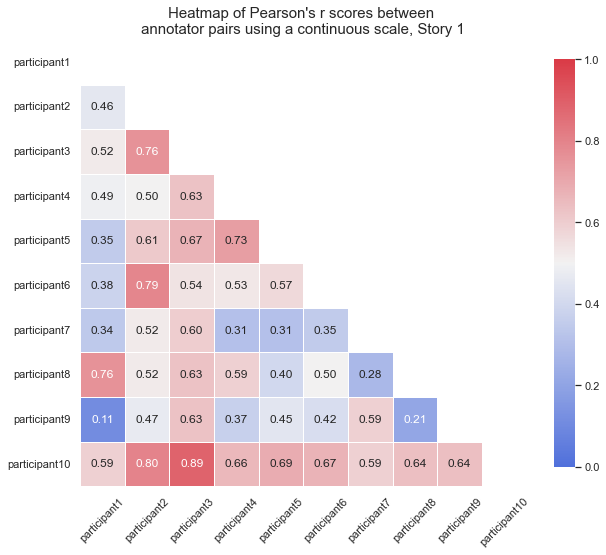

In [64]:




heatmap_panelIOU_pilot = create_heatmap_between_annotators_for_one_story(combinations_all_participants_study2, 
                                                          pearsons_values_study2,
                                                          study2_annotators,
                                                          "Heatmap of Pearson's r scores between \n annotator pairs using a continuous scale, Story 1 ")


